In [1]:
import tensorflow as tf
import numpy as np
import h5py
from importlib import reload
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow.keras as keras
from transformers import TFBertModel, TFBertForQuestionAnswering
import tensorflow.keras.backend as K
from BERTVision.utils.evaluation import *
import BERTVision
import matplotlib.pyplot as plt

In [2]:
dev_answers = SquadDevAnswers('../SQuADv2/',
                 '../SQuADv2/dev_386.h5',
                 qas_ids = 'dev_qas_id',
                 config = Squad2Config())

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:04<00:00,  7.02it/s]


### Load logits predicted by models for analysis

In [3]:
#Model order:
#3/10 epoch model
#3/10 epoch model evaluated at 1 epoch embeddings
#1 epoch model
#BERT at 3/10 epochs
#BERT at 1 epochs
#BERT at 2 epochs

#LOGITS FILES are 0.25GB so not part of GitHub. Available upon request
data_dir = 'logits_best_models'
txts = ['3_10_eval_3_10.txt', '3_10_eval_1.txt', '1_eval_1.txt',
        'bert_3_10.txt', 'bert_1.txt', 'bert_2.txt']
start_logits = []
end_logits = []


for i in txts:
    dat = np.loadtxt(i, dtype = np.float32)
    start, end = np.split(dat, 2, axis = 0)
    start_logits.append(start)
    end_logits.append(end)

### Confirm EM/F1 values, and get per example EM/F1

In [4]:
EM = []
F1 = []

for i,j in enumerate(txts):
    start, end = start_logits[i], end_logits[i]
    e, f = BERTVision.utils.evaluation.SquadModelEvaluation(1, dev_answers, start, end, already_prob=False).evaluate_metrics()
    EM.append(e)
    F1.append(f)

Exact match: 0.699
F1 score: 0.740
Exact match: 0.745
F1 score: 0.791
Exact match: 0.749
F1 score: 0.790
Exact match: 0.654
F1 score: 0.702
Exact match: 0.728
F1 score: 0.777
Exact match: 0.747
F1 score: 0.792


### Model Ensembling

In [5]:
def ensemble_two_models_add(model_1_start, model_1_end, model_2_start, model_2_end):
    a1 = np.exp(model_1_start)/np.sum(np.exp(model_1_start), axis = 1, keepdims = True)
    a2 = np.exp(model_2_start)/np.sum(np.exp(model_2_start), axis = 1, keepdims = True)
    b1 = np.exp(model_1_end)/np.sum(np.exp(model_1_end), axis = 1, keepdims = True)
    b2 = np.exp(model_2_end)/np.sum(np.exp(model_2_end), axis = 1, keepdims = True)
    start = a1+a2
    end = b1+b2
    ensemble_EM, ensemble_F1 = BERTVision.utils.evaluation.SquadModelEvaluation(model_1_start, dev_answers, start, end, already_prob=True).evaluate_metrics()
    return ensemble_EM, ensemble_F1

#Max presented for the paper
def ensemble_two_models_max(model_1_start, model_1_end, model_2_start, model_2_end):
    #Calculate the softmax values for each predicted start/end span
    a1 = np.exp(model_1_start)/np.sum(np.exp(model_1_start), axis = 1, keepdims = True)
    a2 = np.exp(model_2_start)/np.sum(np.exp(model_2_start), axis = 1, keepdims = True)
    b1 = np.exp(model_1_end)/np.sum(np.exp(model_1_end), axis = 1, keepdims = True)
    b2 = np.exp(model_2_end)/np.sum(np.exp(model_2_end), axis = 1, keepdims = True)
    
    #Take the max of each value element-wise for all predictions
    start = np.maximum(a1, a2)
    end = np.maximum(b1, b2)
    ensemble_EM, ensemble_F1 = BERTVision.utils.evaluation.SquadModelEvaluation(model_1_start, dev_answers, start, end, already_prob=True).evaluate_metrics()
    return ensemble_EM, ensemble_F1


#### Ensemble of 3/10 epoch model with BERT predictions at 3/10 epoch

In [6]:
ensemble_EM_3_10_epoch, ensemble_F1_3_10_epoch = ensemble_two_models_max(start_logits[0], end_logits[0], 
                                                                   start_logits[3], end_logits[3])

Exact match: 0.691
F1 score: 0.734


#### Ensemble of 1 epoch model with BERT predictions at 1 epoch

In [7]:
ensemble_EM_1_epoch, ensemble_F1_1_epoch = ensemble_two_models_max(start_logits[2], end_logits[2], 
                                                                   start_logits[4], end_logits[4])

Exact match: 0.756
F1 score: 0.798


#### Had Answer vs No Answer

In [8]:
#Get an array representing whether a question has an answer based on Squad Examples
is_impossible = np.array([dev_answers.examples[i].is_impossible for i in range(len(dev_answers.examples))])

def frac_right_that_is_impossible(model):
    model = np.array(model)
    n, y = np.sum(model[is_impossible]), np.sum(model[np.invert(is_impossible)])
    return n, y
    #return n/(n+y), y/(n+y)

In [9]:
#Number impossible
sum(is_impossible)

5945

In [10]:
#Number not impossible
len(is_impossible) - sum(is_impossible)

5928

In [11]:
imp, not_imp = [], []

#Iterate through the EM vectors for each model and find the fraction that is impossible/not impossible answered correctly
for i in EM:
    c = frac_right_that_is_impossible(i)
    imp.append(c[0])
    not_imp.append(c[1])
    

In [12]:
imp

[4793, 4882, 4961, 3798, 4406, 4763]

In [13]:
#3/10 epoch model
#3/10 epoch model evaluated at 1 epoch embeddings
#1 epoch model
#BERT at 3/10 epochs
#BERT at 1 epochs
#BERT at 2 epochs

In [14]:
xlabels = ['Model_3/10', 'Model_mixed', 'Model_1_epoch', 'BERT_3/10', 'BERT_1_epoch', 'BERT_2_epoch', ]

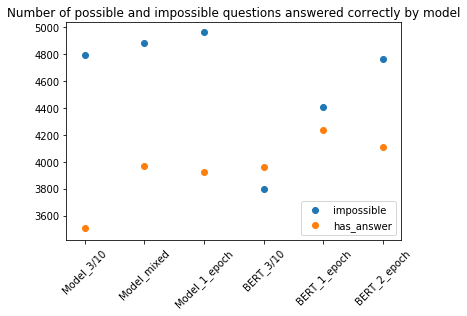

In [15]:
plt.scatter(xlabels, imp, label = 'impossible')
plt.scatter(xlabels, not_imp, label = 'has_answer')
plt.xticks(rotation=45)
plt.title("Number of possible and impossible questions answered correctly by model")
plt.legend()

### Context length

In [16]:
#Get the length of the context by apply the wordpiece tokenizer
tokenizer = Squad2Config().tokenizer
length_context = [len(tokenizer.tokenize(i.context_text)) for i in dev_answers.examples]

#### Context length for all questions

In [17]:
#Out 3/10 epoch model
np.array(length_context)[np.array(EM[0], dtype = bool)].mean()

164.49518304431598

In [18]:
#BERT at 3/10 epoch
np.array(length_context)[np.array(EM[3], dtype = bool)].mean()

165.8602164390621

In [19]:
#Model at 1 epoch
np.array(length_context)[np.array(EM[2], dtype = bool)].mean()

164.39232673267327

In [20]:
#BERT at 1 epoch
np.array(length_context)[np.array(EM[4], dtype = bool)].mean()

165.8988425925926

#### Context length for uniquely correctly answered questions

In [21]:
#At 3/10 epoch, our model correct, and BERT incorrect
np.array(length_context)[np.array(EM[0]).astype(bool) & (1 - np.array(EM[3])).astype(bool)].mean()

161.5788156797331

In [22]:
#At 3/10 epoch, Our model incorrect, and BERT correct
np.array(length_context)[(1-np.array(EM[0])).astype(bool) & np.array(EM[3]).astype(bool)].mean()

175.2998477929985

In [23]:
#At 1 epoch, our model correct, and BERT incorrect
np.array(length_context)[np.array(EM[2]).astype(bool) & (1 - np.array(EM[4])).astype(bool)].mean()

158.6848816029144

In [24]:
#At 1 epoch, our model incorrect, and BERT correct
np.array(length_context)[(1-np.array(EM[2])).astype(bool) & np.array(EM[4]).astype(bool)].mean()

172.3329411764706

### Second best answer

In [25]:
#First, for the maximum position, set probability to 0 (logit to -1000)
start = np.copy(start_logits[0])
end = np.copy(end_logits[0])
for row in start:
    m_idx = np.argmax(row)
    row[m_idx] = -1000
    
for row in end:
    m_idx = np.argmax(row)
    row[m_idx] = -1000


In [26]:
#Get list of EM and F1
second_best_EM, second_best_F1 = BERTVision.utils.evaluation.SquadModelEvaluation(1, dev_answers, start, end, already_prob=False).evaluate_metrics()

Exact match: 0.174
F1 score: 0.240


#### Number second best gets correct where original was incorrect

In [27]:
#Where original answer was incorrect, how many are correct
#second best answer gets 1575/3569 correct!
np.sum(np.array(second_best_EM)[np.array(EM[0]) == 0])

1575

#### Fraction of such questions that were answerable

In [28]:
#Number correct with an answer by the second best answer
np.array(second_best_EM)[(1-is_impossible).astype(bool)].sum()

739

In [29]:
#Sometimes, both best guess and second best guess gets it right 
#This happen when there's no answer, and both best guess and second best guess has start span
#at a position after end span
#Small number of such questions
np.sum(np.array(second_best_EM)[np.array(EM[0]) == 1])

492

In [30]:
#number correct without an answer; so about 50/50
np.array(second_best_EM)[(is_impossible).astype(bool)].sum() - 492

836

### Training data token lengths

In [31]:
train_data = h5py.File('../SQuADv2/train.h5', 'r')
train_ids = np.array(train_data['input_ids'], dtype = np.int32)
train_masks = np.array(train_data['attention_mask'], dtype = np.int32)
train_tokens = np.array(train_data['token_type_ids'], dtype = np.int32)

In [32]:
#For the length, don't count padding tokens
lengths = np.sum(train_ids > 0, axis = 1)

(array([ 6214., 27564., 49806., 25743., 11927.,  5269.,  2039.,   944.,
          558.,   507.]),
 array([ 35. ,  82.7, 130.4, 178.1, 225.8, 273.5, 321.2, 368.9, 416.6,
        464.3, 512. ]),
 <a list of 10 Patch objects>)

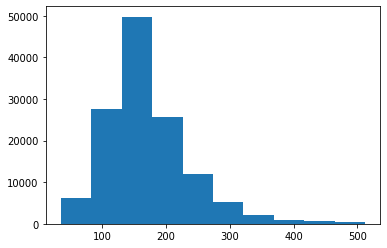

In [33]:
plt.hist(lengths)

In [34]:
np.percentile(lengths, 98), np.percentile(lengths, 99)

(348.0, 402.0)

#### Tenney Learned pooling weights

In [35]:
class BertConcat(layers.Layer):
    def __init__(self, units = 1):
        super().__init__()
        
        #Will only work currently with units = 1
        self.units = 1
        
    def build(self, input_shape):
        self.w = self.add_weight(shape = (input_shape[-1],), trainable = True, initializer = 'random_normal', name = 'w')
        self.t = self.add_weight(shape = (1), trainable = True, initializer = 'ones', name = 't')
    def call(self, inputs):
        w = tf.nn.softmax(self.w)
        return tf.reduce_sum(tf.multiply(inputs, w), axis = -1) * self.t

def baseline_model():
    inp = layers.Input(shape = (386, 1024, 25), dtype = tf.float32)
    x = BertConcat()(inp)
    x = layers.Dense(2)(x)
    start, end = tf.split(x, 2, axis=-1)
    start = tf.squeeze(start, axis = -1)
    end = tf.squeeze(end, axis = -1)
    model = Model(inputs = inp, outputs = [start, end])
    return model

tenney = baseline_model()
tenney.load_weights('weights_best_models/learned_pooling_alone.h5')
normalized_weights = tf.nn.softmax(tenney.weights[0]).numpy()

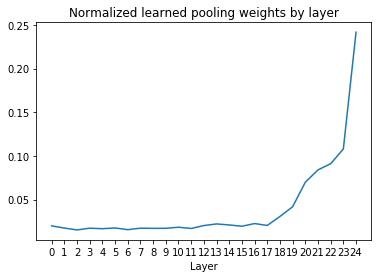

In [36]:
plt.plot(normalized_weights)
plt.title("Normalized learned pooling weights by layer")
plt.xlabel("Layer")
labels = plt.xticks(range(25))